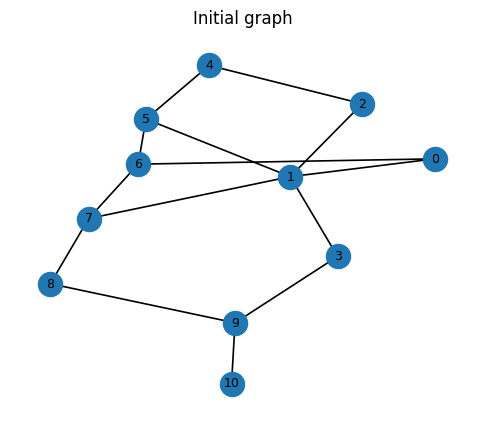

Reward matrix R (excerpt):
[[ -1   0  -1  -1  -1  -1   0  -1  -1  -1  -1]
 [  0  -1   0   0  -1   0  -1   0  -1  -1  -1]
 [ -1   0  -1  -1   0  -1  -1  -1  -1  -1  -1]
 [ -1   0  -1  -1  -1  -1  -1  -1  -1   0  -1]
 [ -1  -1   0  -1  -1   0  -1  -1  -1  -1  -1]
 [ -1   0  -1  -1   0  -1   0  -1  -1  -1  -1]
 [  0  -1  -1  -1  -1   0  -1   0  -1  -1  -1]
 [ -1   0  -1  -1  -1  -1   0  -1   0  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1   0  -1   0  -1]
 [ -1  -1  -1   0  -1  -1  -1  -1   0  -1 100]
 [ -1  -1  -1  -1  -1  -1  -1  -1  -1   0 100]]

Trained Q table (scaled):
[[  0.   42.2   0.    0.    0.    0.   31.6   0.    0.    0.    0. ]
 [ 31.6   0.   31.6  56.2   0.   31.6   0.   42.2   0.    0.    0. ]
 [  0.   42.2   0.    0.   23.7   0.    0.    0.    0.    0.    0. ]
 [  0.   42.2   0.    0.    0.    0.    0.    0.    0.   75.    0. ]
 [  0.    0.   31.6   0.    0.   31.6   0.    0.    0.    0.    0. ]
 [  0.   42.2   0.    0.   23.7   0.   31.6   0.    0.    0.    0. ]
 [ 31.6   0.  

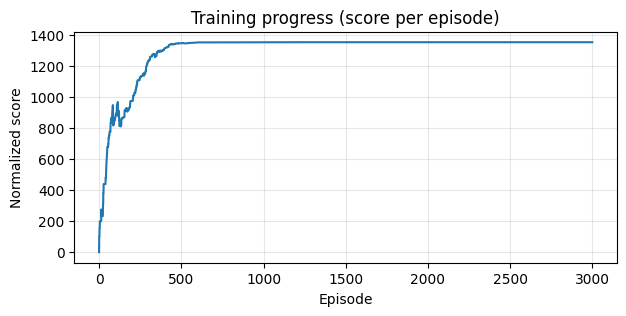

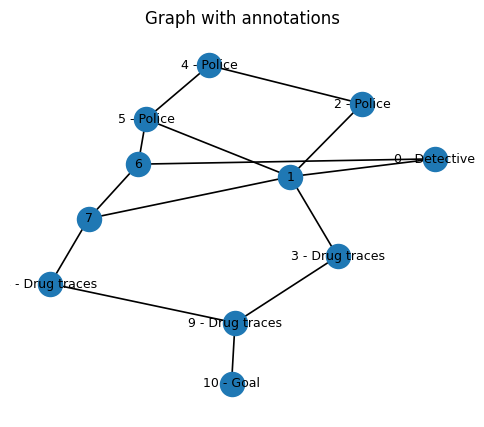


Environmental matrices after exploration:
Police found counts (rows=from-state, cols=action):
[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  0 49  0  0  0  0  0]
 [ 0  0  0  0 90  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 78  0  0 86  0  0  0  0  0]
 [ 0  0  0  0 65  0  0  0  0  0  0]
 [ 0  0  0  0  0 66  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]]

Drug trace counts:
[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 38  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 82  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 58  0  0]
 [ 0  0  0  0  0  0  0  0  0 90  0]
 [ 0  0  0 73  0  0  0  0 60  0  0]
 [ 0  0  0  0  0  0  0  0  0 85  0]]


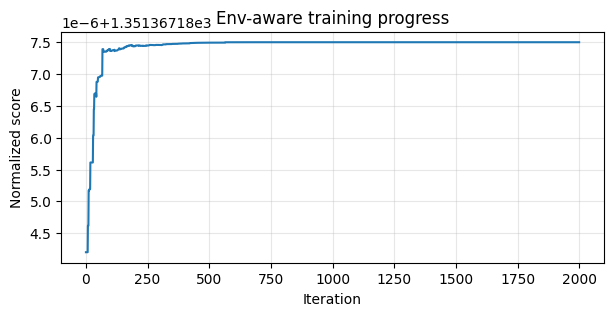

In [ ]:
#Deep reinforcement learning

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Graph edges and goal node
edges = [
    (0, 1), (1, 5), (5, 6), (5, 4), (1, 2),
    (1, 3), (9, 10), (2, 4), (0, 6), (6, 7),
    (8, 9), (7, 8), (1, 7), (3, 9)
]
GOAL = 10
MATRIX_SIZE = 11

def build_graph(edges):
    G = nx.Graph()
    G.add_edges_from(edges)
    return G

def plot_graph(G, title="Graph (nodes labeled by index)"):
    pos = nx.spring_layout(G, seed=SEED)   # seeded layout for reproducibility
    plt.figure(figsize=(6, 5))
    nx.draw_networkx_nodes(G, pos, node_size=300)
    nx.draw_networkx_edges(G, pos, width=1.2)
    nx.draw_networkx_labels(G, pos, font_size=9)
    plt.title(title)
    plt.axis('off')
    plt.show()

def build_reward_matrix(edges, goal, size):
    """
    Create reward matrix R where:
      - R[i, j] = 100 when j is the goal
      - R[i, j] = 0 for allowed moves
      - R[i, j] = -1 for disallowed moves
    """
    R = -1 * np.ones((size, size), dtype=float)
    for (a, b) in edges:
        # allowed moves both directions
        if b == goal:
            R[a, b] = 100.0
        else:
            R[a, b] = 0.0

        if a == goal:
            R[b, a] = 100.0
        else:
            R[b, a] = 0.0

    R[goal, goal] = 100.0
    return R

def available_actions(R, state):
    """Return list of available actions from a state (where R >= 0)"""
    return np.where(R[state] >= 0)[0]

def sample_next_action(available_actions_array):
    """Randomly choose one action from the provided available actions array"""
    if len(available_actions_array) == 0:
        raise ValueError("No available actions from this state.")
    return int(np.random.choice(available_actions_array, 1)[0])

def train_q(R, gamma=0.75, episodes=1000, verbose=False):
    """
    Train a Q-table using simple Q-learning update:
      Q(s,a) = R(s,a) + gamma * max_a' Q(a, a')
    Returns Q and a list of "scores" tracked per episode (normalized)
    """
    size = R.shape[0]
    Q = np.zeros_like(R)
    scores = []

    for ep in range(episodes):
        current_state = np.random.randint(0, size)
        available = available_actions(R, current_state)
        action = sample_next_action(available)

        # standard update
        max_q = np.max(Q[action])
        Q[current_state, action] = R[current_state, action] + gamma * max_q

        # normalized score for monitoring training progress
        if np.max(Q) > 0:
            score = np.sum(Q / np.max(Q) * 100)
        else:
            score = 0.0
        scores.append(score)

        if verbose and (ep + 1) % (episodes // 5 if episodes >= 5 else 1) == 0:
            print(f"Episode {ep+1}/{episodes}, score={score:.2f}")

    return Q, scores

def extract_path(Q, start, goal):
    """
    Given a trained Q-table, follow greedy policy from start to goal.
    If stuck (no positive Q entries), returns current path.
    """
    current_state = start
    path = [current_state]
    safety_counter = 0
    max_steps = Q.shape[0] * 4

    while current_state != goal and safety_counter < max_steps:
        next_indices = np.where(Q[current_state] == np.max(Q[current_state]))[0]
        # choose randomly among ties
        if next_indices.shape[0] > 1:
            next_state = int(np.random.choice(next_indices, size=1))
        else:
            next_state = int(next_indices[0])
        path.append(next_state)
        current_state = next_state
        safety_counter += 1

    return path

# ---------- Basic training & testing ----------
G = build_graph(edges)
plot_graph(G, "Initial graph")

R = build_reward_matrix(edges, GOAL, MATRIX_SIZE)
print("Reward matrix R (excerpt):")
print(R.astype(int))   # cast to int for compact print

Q, scores = train_q(R, gamma=0.75, episodes=3000, verbose=False)

print("\nTrained Q table (scaled):")
if np.max(Q) > 0:
    print(np.round(Q / np.max(Q) * 100, 1))
else:
    print(Q)

# Test greedy path from node 0 to GOAL
start_state = 0
path = extract_path(Q, start_state, GOAL)
print("\nMost efficient path (greedy on learned Q):", path)

plt.figure(figsize=(7, 3))
plt.plot(scores)
plt.title("Training progress (score per episode)")
plt.xlabel("Episode")
plt.ylabel("Normalized score")
plt.grid(alpha=0.3)
plt.show()

# ---------- Environment-aware exploration (police/drugs) ----------
# Define labels and environment objects
police_nodes = [2, 4, 5]
drug_trace_nodes = [3, 8, 9]

# Relabel for visualization (human-friendly labels)
mapping = {
    0: '0 - Detective', 1: '1', 2: '2 - Police', 3: '3 - Drug traces',
    4: '4 - Police', 5: '5 - Police', 6: '6', 7: '7',
    8: '8 - Drug traces', 9: '9 - Drug traces', 10: '10 - Goal'
}
H = nx.relabel_nodes(G, mapping)
plot_graph(H, "Graph with annotations")

# Environmental counters: how many times taking (s->a) found police / drugs
env_police = np.zeros((MATRIX_SIZE, MATRIX_SIZE), dtype=int)
env_drugs = np.zeros((MATRIX_SIZE, MATRIX_SIZE), dtype=int)

def collect_environmental_data(action, police_nodes, drug_nodes):
    """
    Return list with letters 'p' if police present at action node,
    and 'd' if drug traces present.
    """
    found = []
    if action in police_nodes:
        found.append('p')
    if action in drug_nodes:
        found.append('d')
    return found

# Reset Q for second phase (you can also continue training from previous Q)
Q2 = np.zeros_like(R)
scores_env = []

def update_with_environment(Q, R, current_state, action, gamma,
                            env_police, env_drugs, police_nodes, drug_nodes):
    max_q = np.max(Q[action])
    Q[current_state, action] = R[current_state, action] + gamma * max_q
    environment = collect_environmental_data(action, police_nodes, drug_nodes)
    if 'p' in environment:
        env_police[current_state, action] += 1
    if 'd' in environment:
        env_drugs[current_state, action] += 1
    if np.max(Q) > 0:
        return np.sum(Q / np.max(Q) * 100)
    else:
        return 0.0

# Explore environment and update counters
for i in range(2000):
    cur = np.random.randint(0, Q2.shape[0])
    av = available_actions(R, cur)
    act = sample_next_action(av)
    _ = update_with_environment(Q2, R, cur, act, gamma=0.75,
                                env_police=env_police, env_drugs=env_drugs,
                                police_nodes=police_nodes, drug_nodes=drug_trace_nodes)

print("\nEnvironmental matrices after exploration:")
print("Police found counts (rows=from-state, cols=action):")
print(env_police)
print("\nDrug trace counts:")
print(env_drugs)

# Now use environment-aware available-actions: disfavour actions with observed negative signal.
def available_actions_with_env_help(R, Q_snapshot, state):
    av = available_actions(R, state)
    if len(av) == 0:
        return av
    # Use Q_snapshot as a proxy for preference; dis-favour actions with strictly negative Q entries
    qvals = Q_snapshot[state, av]
    # keep only actions with q >= 0 (if any)
    good_mask = np.array(qvals >= 0).reshape(-1)
    if np.any(good_mask):
        av = av[good_mask]
    return av


scores_env2 = []
for i in range(2000):
    cur = np.random.randint(0, Q2.shape[0])
    av = available_actions_with_env_help(R, Q2, cur)
    if len(av) == 0:  # fallback
        av = available_actions(R, cur)
    act = sample_next_action(av)
    s = update_with_environment(Q2, R, cur, act, gamma=0.75,
                                env_police=env_police, env_drugs=env_drugs,
                                police_nodes=police_nodes, drug_nodes=drug_trace_nodes)
    scores_env2.append(s)

plt.figure(figsize=(7, 3))
plt.plot(scores_env2)
plt.title("Env-aware training progress")
plt.xlabel("Iteration")
plt.ylabel("Normalized score")
plt.grid(alpha=0.3)
plt.show()
